In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import naive_bayes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import wordcloud
from sklearn import metrics

In [2]:
def autolabel(rect):
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2.-0.2, 1.03*height, '%s' % float(height))

In [3]:
df = pd.read_csv("data.csv")
df.head()

,vote,user,user_url,star,level,release_time,content
0,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,2020-01-06,喜欢那个打黑拳！！
1,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,2020-01-06,还可以吧。
2,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,2020-01-06,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...
3,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020-01-06,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。
4,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,2020-01-06,适合消遣看看，破梗废话太多……


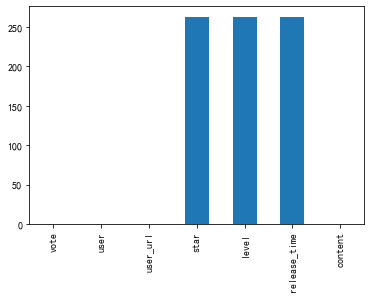

In [4]:
# 检查缺失值
df.isnull().sum(axis=0).plot.bar()

In [5]:
df = df.dropna()
df["release_time"] = pd.to_datetime(df["release_time"])
df = df.set_index("release_time")
df.head()

,vote,user,user_url,star,level,content
release_time,,,,,,
2020-01-06,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,喜欢那个打黑拳！！
2020-01-06,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,还可以吧。
2020-01-06,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...
2020-01-06,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。
2020-01-06,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,适合消遣看看，破梗废话太多……


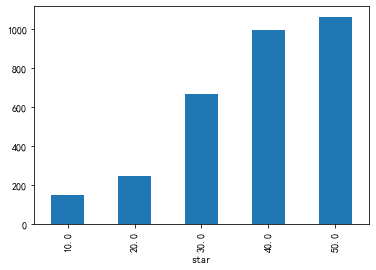

In [6]:
# 评分等级条形图
df.groupby("star")["star"].count().plot.bar()

In [7]:
# 用户评论数量排序
df.groupby("user")["user"].count().sort_values(ascending=False)[:20]

user
[已注销]     60
已注销       12
Allen      3
Flora      2
卷卷         2
NEMO       2
猫小爷        2
豆瓣酱        2
六月         2
水中游鱼       2
Phoebe     2
leo        2
豆爸         2
无为         2
z          2
流言         2
艾瑞巴蒂       2
S          2
kevin      2
无言         2
Name: user, dtype: int64

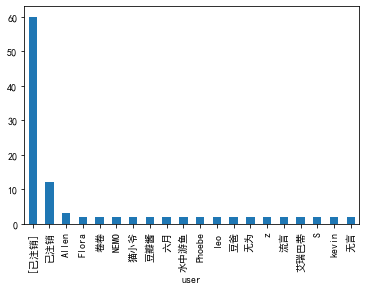

In [8]:
# 用户评论数量排序条形图
df.groupby("user")["user"].count().sort_values(ascending=False)[:20].plot.bar()

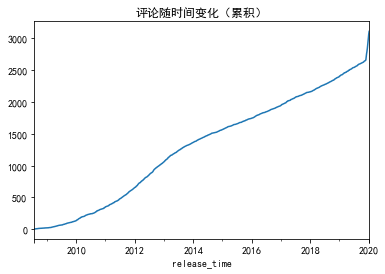

In [9]:
# 评论随时间变化（累积）
df_day = df.to_period('D')
df_day.groupby(df_day.index)["content"].count().cumsum().plot(title='评论随时间变化（累积）')

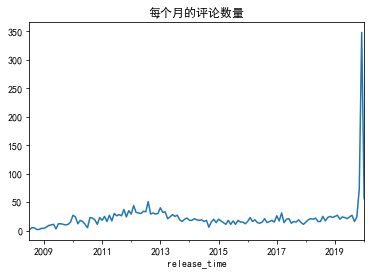

In [10]:
# 每个月的评论数量
df_day = df.to_period('M')
df_day.groupby(df_day.index)["content"].count().plot(title="每个月的评论数量")

In [11]:
df.sort_values(by="vote", ascending=False)[:50]

,vote,user,user_url,star,level,content
release_time,,,,,,
2013-06-10,335,水湄物语,https://www.douban.com/people/foxsshome/,20.0,较差,@棠华 完全不好看啊，我不喜欢这种天纵奇才的设定，武功天下无敌，背景深不可测，加上英俊无比...
2015-08-28,304,鱼丸粗面,https://www.douban.com/people/sampaning/,30.0,还行,YY的连我这看书的人都有点不好意思了，上来就无耻地穿越到小孩身上（人小鬼大），还身怀天脉，过...
2015-06-29,189,川总,https://www.douban.com/people/reflect/,10.0,很差,难负盛名，废话连篇
2013-10-06,188,时间.世界,https://www.douban.com/people/1998897/,20.0,较差,1星半。
2016-12-07,71,贝利撒留.ape,https://www.douban.com/people/43340854/,50.0,力荐,发现一个神奇的现象，给这本网络小说打低分并给予负面评价的网友里，很多都给按他们的标准更差的小...
2013-09-15,64,红药石,https://www.douban.com/people/hongyaoshi/,20.0,较差,看过，中途弃书，作者一看就是个喜欢YY的男生，左右逢源，集万千高富美宠爱于一身，此等设定让我...
2010-02-05,64,苦茶,https://www.douban.com/people/Wangtanzhi/,20.0,较差,语言粗糙，故事混乱。不值得推荐。看了近一半之后，废弃不观。
2014-06-30,59,恶魔奶爸Sam,https://www.douban.com/people/Q598176297/,30.0,还行,主角太讨人厌，看了一半看不下去了，搜了下结局，剧透的连底裤都透掉了，继承了猫腻一如既往结尾不...
2015-06-12,39,喵咪,https://www.douban.com/people/42444039/,20.0,较差,根本看不下去，完全不明白为什么好评那么多……


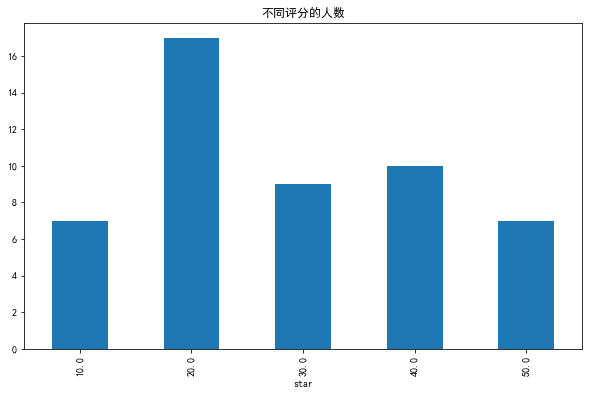

In [76]:
# 高赞的50个评论的评分等级条形图
df.sort_values(by="vote", ascending=False)[:50].groupby("star")["star"].count()\
  .plot.bar(title="不同评分的人数", figsize=(10, 6))

In [13]:
# 根据评分划分情感倾向
df.loc[df["star"] <= 30,'sentiment'] = 0
df.loc[df["star"] > 30,'sentiment'] = 1
df.head()

,vote,user,user_url,star,level,content,sentiment
release_time,,,,,,,
2020-01-06,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,喜欢那个打黑拳！！,1.0
2020-01-06,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,还可以吧。,0.0
2020-01-06,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1.0
2020-01-06,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0.0
2020-01-06,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,适合消遣看看，破梗废话太多……,0.0


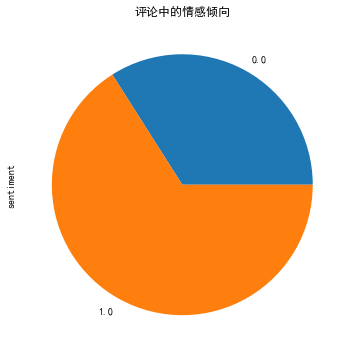

In [73]:
df.groupby("sentiment")["sentiment"].count().plot.pie(title="评论中的情感倾向", figsize=(8, 6))

In [14]:
# 分词函数，没有停用词
def space_cut(intxt):
    return " ".join([w for w in jieba.cut(intxt)])

def list_cut(intxt):
    return [w for w in jieba.cut(intxt)]

# 将语料分词
df["cut"] = df["content"].apply(space_cut)
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/wq/03z5h7352159jp2k5p83ts500000gn/T/jieba.cache
Loading model cost 0.786 seconds.
Prefix dict has been built successfully.


,vote,user,user_url,star,level,content,sentiment,cut
release_time,,,,,,,,
2020-01-06,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,喜欢那个打黑拳！！,1.0,喜欢 那个 打黑 拳 ！ ！
2020-01-06,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,还可以吧。,0.0,还 可以 吧 。
2020-01-06,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1.0,其实 已经 一口气 狂 看到 了 第七卷 。 前半 的 节奏 还是 意气风发 无往不利 ， ...
2020-01-06,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0.0,2020 年头 的 几天 假期 啥事 没干 ， 就 看 这 几百万 字 了 。 真的 要 戒...
2020-01-06,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,适合消遣看看，破梗废话太多……,0.0,适合 消遣 看看 ， 破梗 废话 太 多 … …


In [61]:
# 查看缺失值
df.isnull().sum(axis=0)

vote         0
user         0
user_url     0
star         0
level        0
content      0
sentiment    0
cut          0
dtype: int64

/Users/nick/.venv/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


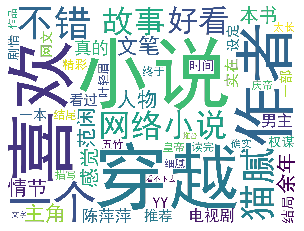

In [15]:
# 词云
# 字体
myfont = "../../StaticFile/SimHei.ttf"
# 停用词路径
stoplistdf = pd.read_csv('停用词.txt', names=["w"], sep="aaa", encoding="utf-8")
stoplist_wdc = list(stoplistdf.w)

# 词云 将所有的帖子进行分词，统计词频，展示词云
gennerate_string = ""
for c in df["cut"]:
    gennerate_string += c

# 生成词云对象
cloudobj = wordcloud.WordCloud(font_path = myfont, 
    width = 2000, height = 1500, max_words = 50,
    mode = "RGBA", background_color = None,
    stopwords = stoplist_wdc, collocations=False).generate(gennerate_string)  

plt.imshow(cloudobj)
plt.axis("off")
plt.show()

In [49]:
cut_data = pd.DataFrame(df["cut"])
cut_data = cut_data.reset_index()
cut_data = cut_data.drop(["release_time"], axis=1)
cut_data.head()

,cut
0,喜欢 那个 打黑 拳 ！ ！
1,还 可以 吧 。
2,其实 已经 一口气 狂 看到 了 第七卷 。 前半 的 节奏 还是 意气风发 无往不利 ， ...
3,2020 年头 的 几天 假期 啥事 没干 ， 就 看 这 几百万 字 了 。 真的 要 戒...
4,适合 消遣 看看 ， 破梗 废话 太 多 … …


In [54]:
x_train, x_test, y_train, y_test = train_test_split(cut_data["cut"], df["sentiment"], test_size=0.3, random_state=30)

In [55]:
# 词袋模型-矩阵
vect = CountVectorizer()
x_train_vect = vect.fit_transform(x_train)
x_test_vect = vect.transform(x_test)
print(x_train_vect.shape)

(2177, 6692)


In [56]:
# tfidf-矩阵
transf = TfidfTransformer()
x_train_tfidf = transf.fit_transform(x_train_vect)
x_test_tfidf = transf.transform(x_test_vect)
print(x_train_tfidf.todense().shape)  # print(vect.vocabulary_)

(2177, 6692)


In [57]:
# 词袋模型-朴素贝叶斯
nbmodel = naive_bayes.MultinomialNB()
nbmodel.fit(x_train_vect, y_train)
# 预测
y_predict = nbmodel.predict(x_test_vect)
# 预测准确率
train_score = nbmodel.score(x_train_vect, y_train)
test_score = nbmodel.score(x_test_vect, y_test)

print("【词袋模型-朴素贝叶斯】train_score: {} test_score: {}".format(train_score, test_score))

【词袋模型-朴素贝叶斯】train_score: 0.9150206706476803 test_score: 0.7537473233404711


In [58]:
y_prob = nbmodel.predict_proba(x_test_vect)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print("** auc_value: 【{}】 **".format(auc_value))

** auc_value: 【0.744622410664167】 **


In [95]:
ks = max(tpr-fpr)
ks

0.33077556092058

In [87]:
result = pd.DataFrame(x_test)
result["sentiment"] = y_predict
result = result.reset_index()
result = result.drop(["index"], axis=1)
result

,cut,sentiment
0,叹 小 叶子 这么 强大 的 工科 女博士 也 被 爱情 击败 了,1.0
1,鹦鹉 史航 说 这 是 他 “ 最 喜欢 的 网络 穿越 小说 ” 。 他 喜欢 的 ， 大...,1.0
2,第一本 ， 真的 很 不错,1.0
3,庆 余年 一路 彩虹 将夜 这 类书 看 了 好多 ~ 月关 和 猫...,1.0
4,从头到尾 读完 了 ， 还是 很 精彩 的 。 大局 其实 一般 ， 但 有 几段 重头戏 ...,1.0
5,我 真的 不 适合 读 男频 ， 特别 是 那种 不是 1v1 的,0.0
6,看 了 四遍,1.0
7,个人 认为 很 强大 的 一 本书 。,1.0
8,打发 无聊 时间 都 觉得 无聊 。 1 ） 不 喜欢 弱智 的 人物 对话 2 ） 不 喜...,0.0
9,什么 鬼 ， 弃 了,1.0


In [92]:
verify_text = "无聊 时 打发 时间 可以 看看 但是 太长 了 弃	"
verify_text_cut = " ".join(jieba.lcut(verify_text))
verify_text_serise = pd.Series([verify_text])
verify_text_vect = vect.transform(verify_text_serise)
y_prob = nbmodel.predict_proba(verify_text_vect)
pd_dict = {"text": verify_text, "cut": verify_text_cut, "sentiment": y_prob[:, 1]}
pd.DataFrame(pd_dict)

,text,cut,sentiment
0,无聊 时 打发 时间 可以 看看 但是 太长 了 弃\t,无聊 时 打发 时间 可以 看看 但是 太 长 了 弃 \t,0.127797


In [93]:
# 词袋模型-矩阵
vect = CountVectorizer()
x_train_vect = vect.fit_transform(x_train)
x_test_vect = vect.transform(x_test)
print(x_train_vect.shape)


# tfidf-矩阵
transf = TfidfTransformer()
x_train_tfidf = transf.fit_transform(x_train_vect)
x_test_tfidf = transf.transform(x_test_vect)
print(x_train_tfidf.todense().shape)  # print(vect.vocabulary_)


# 词袋模型-朴素贝叶斯
nbmodel = naive_bayes.MultinomialNB()
nbmodel.fit(x_train_tfidf, y_train)
# 预测
y_predict = nbmodel.predict(x_test_tfidf)
# 预测准确率
train_score = nbmodel.score(x_train_tfidf, y_train)
test_score = nbmodel.score(x_test_tfidf, y_test)

print("【tfidf模型-朴素贝叶斯】train_score: {} test_score: {}".format(train_score, test_score))

y_prob = nbmodel.predict_proba(x_test_vect)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print("** auc_value: 【{}】 **".format(auc_value))

(2177, 6692)
(2177, 6692)
【词袋模型-朴素贝叶斯】train_score: 0.8451998162609095 test_score: 0.7430406852248393
** auc_value: 【0.7095011798815213】 **
